# College Scorecard evaluation in Oregon, California and Washington

My (imaginary) daughter is trying to decide what college to attend. We are accessing the data from the College Scorecard from ED.gov for the 2015-16 year to help her narrow down the field of schools she wants to visit. The set includes data on schools across the country to help students and families compare college costs and outcomes as they weigh the tradeoffs of different colleges, accounting for their own needs and educational goals. These data are provided through federal reporting from institutions, data on federal financial aid, and tax information. These data provide insights into the performance of institutions that receive federal financial aid dollars, and the outcomes of the students of those institutions. 

In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
%matplotlib inline

In [2]:
df = pd.read_csv("MERGED2015_16_PP.csv")

c:\users\katieb\appdata\local\programs\python\python36-32\lib\site-packages\IPython\core\interactiveshell.py:2728: DtypeWarning: Columns (6,9,1725,1726,1727,1728,1729,1743) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


My (imaginary) daughter is certain she wants to attend school in either Oregon, California or Washington, so we are only going to evaluate schools in those three states.

In [3]:
or_schools = df.loc[lambda d_f: df['STABBR'] == 'OR' , :]
ca_schools = df.loc[lambda d_f: df['STABBR'] == 'CA' , :]
wa_schools = df.loc[lambda d_f: df['STABBR'] == 'WA' , :]
waca_schools = wa_schools.append(ca_schools)
wcs = waca_schools.append(or_schools)
print(wcs["UNITID"].count())

990


That leaves us with 990 colleges to evaluate.

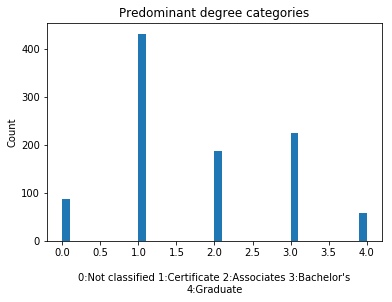

In [4]:
plt.hist(wcs['PREDDEG'], bins = 40)
plt.xlabel('\n0:Not classified 1:Certificate 2:Associates 3:Bachelor\'s\n4:Graduate')
plt.title("Predominant degree categories")
plt.ylabel('Count')
plt.show()

We didn't realize there are a large number of institutions that specialize in Certificate degrees, so we're going to drop the schools whose primary focus is not a bachelor's degree for now, which will help us compare apples to apples when we look at performance data later. 

In [5]:
wcs = wcs.loc[lambda d_f:wcs['PREDDEG'] == 3,:]
print(wcs['UNITID'].count())

225


### The questions of interest

That leaves us with 225 schools for our analysis. In our analysis we want to:
1. Determine some of the general differences between public versus private schools in our population
2. Compare in-state versus out-of-state of this population

The criteria we are most interested in evaluating are, in no particular order:
1. Cost
3. Quality
2. Diversity

This research will help inform our future research where we want to come up with some sort of a scoring matrix that helps us consider all the factors that are important and rank them to find the top 10 schools for her to visit. Before creating the scoring matrix, we want to take a look at some of how the factors of interest are represented in the dataset.

### Analysis

The general assumption is that costs of out-of-state tuition in many cases is much higher than in-state tuition so we take a look at this.

In [6]:
print(waca_schools['TUITIONFEE_OUT'].describe())

count      402.000000
mean     17482.375622
std      12355.079500
min       1154.000000
25%       7224.000000
50%      13888.000000
75%      24023.500000
max      50649.000000
Name: TUITIONFEE_OUT, dtype: float64


In [7]:
print(or_schools['TUITIONFEE_IN'].describe())

count       53.000000
mean     15918.301887
std      13096.551132
min       3555.000000
25%       4725.000000
50%      10800.000000
75%      21460.000000
max      49940.000000
Name: TUITIONFEE_IN, dtype: float64


The difference between the average out-of-state versus the average in-state tuition cost is not as bad as I had feared. Still, from the standard deviations in the summary statistics it looks like there's a fair amount of variation in the samples. The graph below plots the values on a histogram to visualize this, and since there are many more out-of-state schools than in-state ones, I normalize the graphs so that the area under the curves of each is equal to 1.

In [8]:
temp_in = or_schools.loc[lambda d_f: False == np.isnan(or_schools['TUITIONFEE_IN']) , :]
temp_out = waca_schools.loc[lambda d_f: False == np.isnan(waca_schools['TUITIONFEE_OUT']),:]

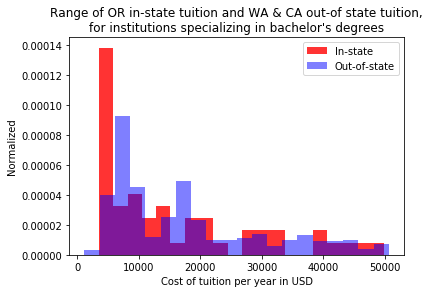

In [9]:
plt.hist(temp_in['TUITIONFEE_IN'], normed=True, color='red',bins=20, alpha=0.8)
plt.hist(temp_out['TUITIONFEE_OUT'], normed=True, color='blue',bins=20, alpha=0.5)
plt.title("Range of OR in-state tuition and WA & CA out-of state tuition,\nfor institutions specializing in bachelor's degrees")
plt.xlabel("Cost of tuition per year in USD")
plt.ylabel("Normalized")
plt.legend(("In-state","Out-of-state"))
plt.show()

From the graph above, the distributions are not normal. Both in-state and out-of-state tuitions are biased to the lower end, in-state a bit more so that out-of-state. However the graph includes both public and private schools. To look at the distributions of costs for public versus private for profit, and private not for profit schools we separate these out below. Private schools charge the same whether you are from in-state or out-of-state, so we compare private schools to Oregon's in-state tuitions, and private schools to WA and CA's out-of-state tuitions.

In [10]:
or_pub = or_schools.loc[lambda d_f: or_schools['CONTROL'] == 1 , :]
or_priv_n = or_schools.loc[lambda d_f: or_schools['CONTROL'] == 2 , :]
or_priv_p = or_schools.loc[lambda d_f: or_schools['CONTROL'] == 3 , :]

waca_pub = waca_schools.loc[lambda d_f: waca_schools['CONTROL'] == 1 , :]
waca_priv_n = waca_schools.loc[lambda d_f: waca_schools['CONTROL'] == 2 , :]
waca_priv_p = waca_schools.loc[lambda d_f: waca_schools['CONTROL'] == 3 , :]

In [11]:
temp_or_pub = or_pub.loc[lambda d_f: False == np.isnan(or_pub['TUITIONFEE_IN']) , :]
temp_or_priv_n = or_priv_n.loc[lambda d_f: False == np.isnan(or_priv_n['TUITIONFEE_OUT']),:]
temp_or_priv_p = or_priv_p.loc[lambda d_f: False == np.isnan(or_priv_p['TUITIONFEE_OUT']),:]

temp_waca_pub = waca_pub.loc[lambda d_f: False == np.isnan(waca_pub['TUITIONFEE_IN']) , :]
temp_waca_priv_n = waca_priv_n.loc[lambda d_f: False == np.isnan(waca_priv_n['TUITIONFEE_OUT']),:]
temp_waca_priv_p = waca_priv_p.loc[lambda d_f: False == np.isnan(waca_priv_p['TUITIONFEE_OUT']),:]

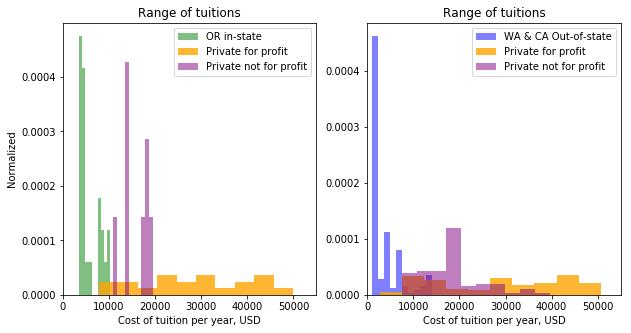

In [12]:
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.hist(temp_or_pub['TUITIONFEE_IN'], normed=True, color='green', alpha=0.5)
plt.hist(temp_or_priv_n['TUITIONFEE_IN'], normed=True, color='orange', alpha=0.8)
plt.hist(temp_or_priv_p['TUITIONFEE_IN'], normed=True, color='purple', alpha=0.5)
plt.title("Range of tuitions")
plt.xlim([0,55000])
plt.xlabel("Cost of tuition per year, USD")
plt.ylabel("Normalized")
plt.legend(("OR in-state","Private for profit", "Private not for profit"))

plt.subplot(1,2,2)
plt.hist(temp_waca_pub['TUITIONFEE_IN'], normed=True, color='blue', label="OR public", alpha=0.5)
plt.hist(temp_waca_priv_n['TUITIONFEE_IN'], normed=True, color='orange', label="Private", alpha=0.8)
plt.hist(temp_waca_priv_p['TUITIONFEE_IN'], normed=True, color='purple', label="Private", alpha=0.5)
plt.xlim([0,55000])

plt.title("Range of tuitions")
plt.xlabel("Cost of tuition per year, USD")
plt.legend(("WA & CA Out-of-state","Private for profit", "Private not for profit"))
plt.show()

From the graphs, private schools seem generally costlier than public schools.

We want to know what bearing the cost of an institution has, and if it has any relationship to its quality, so we look at a few scatter plots to check that out. To be fair, we analyze out-of-state costs, since private schools don't have separate pricing for "in-state" residents, and since state policy helps determine the pricing of in-state tuition for its residents.

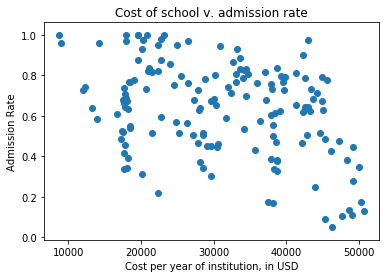

In [13]:
plt.scatter(x=wcs['TUITIONFEE_OUT'], y=wcs['ADM_RATE'])
plt.xlabel('Cost per year of institution, in USD')
plt.ylabel('Admission Rate')
plt.title('Cost of school v. admission rate')
plt.show()

There appears to be some relationship between costs and admission rates, where higher costs tend to have lower admission rates. To see if this relationship might be clearer for private or public schools, we disaggregate the data into these subgroups and look at it again.

In [14]:
pub_wcs = wcs.loc[lambda d_f: wcs['CONTROL'] == 1 , :] #subset of public west coast schools
priv_n_wcs = wcs.loc[lambda d_f: wcs['CONTROL'] == 2 , :] #subset of private nonprofit west coast schools
priv_p_wcs = wcs.loc[lambda d_f: wcs['CONTROL'] == 3 , :] #subset of private for profit west coast schools

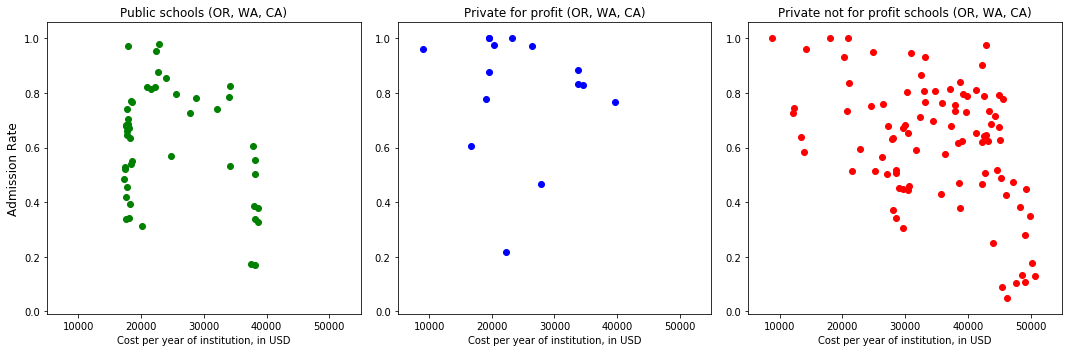

In [15]:
plt.figure(figsize=(15, 5))

ax1 = plt.subplot(1, 3, 1)
plt.scatter(x=pub_wcs['TUITIONFEE_OUT'], y=pub_wcs['ADM_RATE'], color='green')
plt.xlabel('Cost per year of institution, in USD')
plt.ylabel('Admission Rate', fontsize=12)
plt.title('Public schools (OR, WA, CA)')
plt.xlim([5000,55000])

ax2 = plt.subplot(1, 3, 2, sharey=ax1)
plt.scatter(x=priv_p_wcs['TUITIONFEE_OUT'], y=priv_p_wcs['ADM_RATE'], color='blue')
plt.xlabel('Cost per year of institution, in USD')
plt.title('Private for profit (OR, WA, CA)')
plt.xlim([5000,55000])

ax3 = plt.subplot(1, 3, 3, sharey=ax1)
plt.scatter(x=priv_n_wcs['TUITIONFEE_OUT'], y=priv_n_wcs['ADM_RATE'], color='red')
plt.xlabel('Cost per year of institution, in USD')
plt.title('Private not for profit schools (OR, WA, CA)')
plt.xlim([5000,55000])

plt.tight_layout()
plt.show()

The strongest relationship between admission rate and cost of the institution is found in private not for profit schools, where as cost increases the admission rates tend to be lower. The results for private for profit schools and public schools are more ambiguous, but also hint at a similar relationship. Arguably there could be something there that we could tease out with further analysis and larger data sets for the public and private for profit schools, but that is not critical to this analysis so we leave the determination of that exact relationship for future research.

It looks like the higher cost institutions tend to have lower admission rates. Not surprising. Next we look at the relationship between cost and graduation rates.

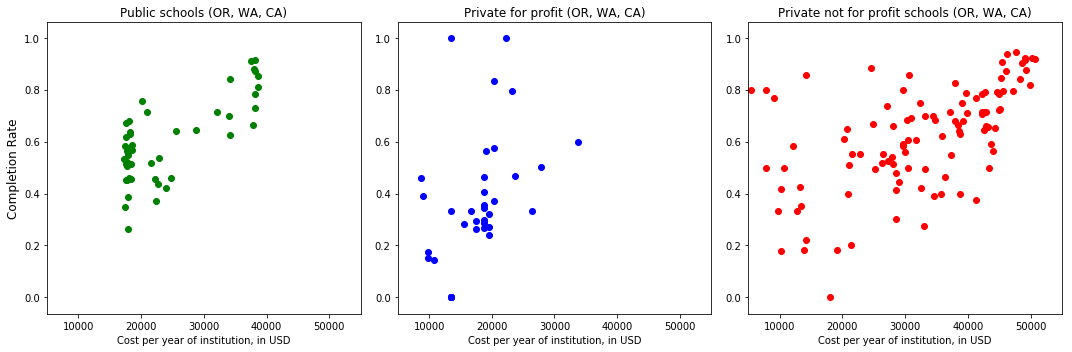

In [16]:
plt.figure(figsize=(15, 5))

ax1 = plt.subplot(1, 3, 1)
plt.scatter(x=pub_wcs['TUITIONFEE_OUT'], y=pub_wcs['C150_4'], color='green')
plt.xlabel('Cost per year of institution, in USD')
plt.ylabel('Completion Rate', fontsize=12)
plt.title('Public schools (OR, WA, CA)')
plt.xlim([5000,55000])

ax2 = plt.subplot(1, 3, 2, sharey=ax1)
plt.scatter(x=priv_p_wcs['TUITIONFEE_OUT'], y=priv_p_wcs['C150_4'], color='blue')
plt.xlabel('Cost per year of institution, in USD')
plt.title('Private for profit (OR, WA, CA)')
plt.xlim([5000,55000])

ax3 = plt.subplot(1, 3, 3, sharey=ax1)
plt.scatter(x=priv_n_wcs['TUITIONFEE_OUT'], y=priv_n_wcs['C150_4'], color='red')
plt.xlabel('Cost per year of institution, in USD')
plt.title('Private not for profit schools (OR, WA, CA)')
plt.xlim([5000,55000])

plt.tight_layout()
plt.show()

There's also generally a relationship between the cost of the school and the completion rate, with costlier schools having higher average completion rates, and this relationship appears to hold up somewhat through the subcategories.

We wanted to a look at whether paying more for a school could lead to higher earnings after graduation, but the earnings data was not available in this dataset. That is something we leave for future research.

Instead we switch our attention to look at the SAT and ACT scores of students entering into the schools, to see which have the highest academic standards for admission.

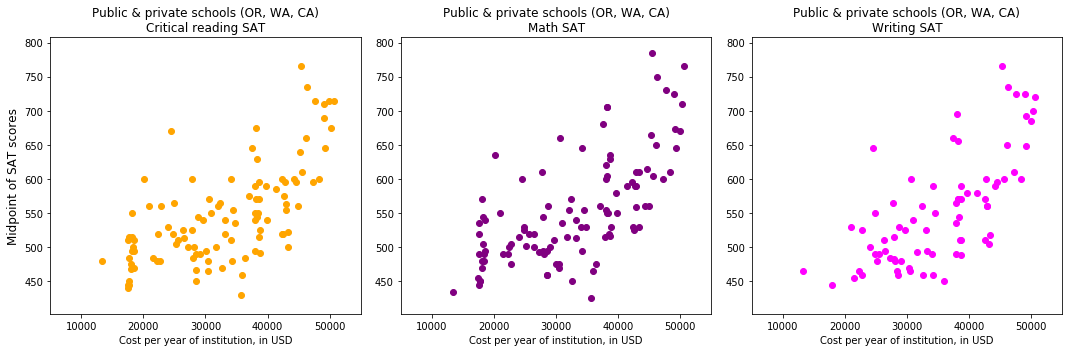

In [17]:
plt.figure(figsize=(15, 5))

ax1 = plt.subplot(1, 3, 1)
plt.scatter(x=wcs['TUITIONFEE_OUT'], y=wcs['SATVRMID'], color='orange')
plt.xlabel('Cost per year of institution, in USD')
plt.ylabel('Midpoint of SAT scores', fontsize=12)
plt.title('Public & private schools (OR, WA, CA)\nCritical reading SAT')
plt.xlim([5000,55000])

ax2 = plt.subplot(1, 3, 2, sharey=ax1)
plt.scatter(x=wcs['TUITIONFEE_OUT'], y=wcs['SATMTMID'], color='purple')
plt.xlabel('Cost per year of institution, in USD')
plt.title('Public & private schools (OR, WA, CA)\nMath SAT')
plt.xlim([5000,55000])

ax3 = plt.subplot(1, 3, 3, sharey=ax1)
plt.scatter(x=wcs['TUITIONFEE_OUT'], y=wcs['SATWRMID'], color='fuchsia')
plt.xlabel('Cost per year of institution, in USD')
plt.title('Public & private schools (OR, WA, CA)\nWriting SAT')
plt.xlim([5000,55000])

plt.tight_layout()
plt.show()

You can see that the midpoint of the SAT increases as the cost of the institution increases, regardless of the subject test. For the ACT cumulative score, we are going to disaggregate the data again into public and private schools. There is only one private for profit school with data for this category, so we drop it from the graph.

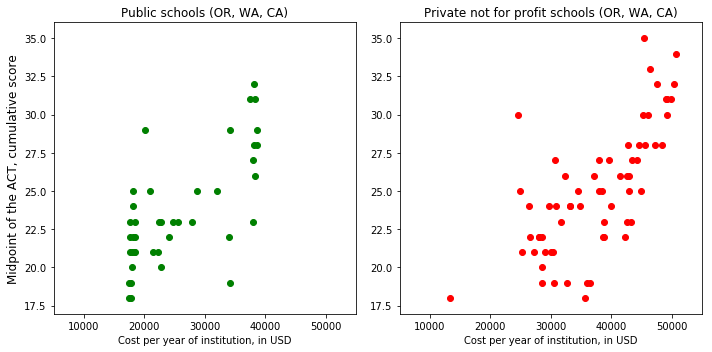

In [18]:
plt.figure(figsize=(10, 5))

ax1 = plt.subplot(1, 2, 1)
plt.scatter(x=pub_wcs['TUITIONFEE_OUT'], y=pub_wcs['ACTCMMID'], color='green')
plt.xlabel('Cost per year of institution, in USD')
plt.ylabel('Midpoint of the ACT, cumulative score', fontsize=12)
plt.title('Public schools (OR, WA, CA)')
plt.xlim([5000,55000])

ax2 = plt.subplot(1, 2, 2, sharey=ax1)
plt.scatter(x=priv_n_wcs['TUITIONFEE_OUT'], y=priv_n_wcs['ACTCMMID'], color='red')
plt.xlabel('Cost per year of institution, in USD')
plt.title('Private not for profit schools (OR, WA, CA)')
plt.xlim([5000,55000])

plt.tight_layout()
plt.show()

The relationship of the ACT to tuition seems similar to that of the SAT, even when disaggregated by school type. The case to spend more on an education is building. Also of note in the above graph is that the highest extreme of ACT scores are found in private schools.

I repeated the above tests using instead the "Cost for attendance" variable, which includes books and supplies and living expenses, and all the graphs looked the same. I've not included those graphs, so as not to be repetitive, but wanted to make sure that the addition of these costs to the tuition didn't impact the relationship to the above factors. It did not, or at least in a way that could easily be seen on these plots.

Before determining the final scoring matrix with which to rank the schools, we take a look at diversity in the schools. We want to make sure there is not a tradeoff between diversity and academic standards. If there is, we will have to create an appropriate weight for the importance of diversity in our scoring. To look at this we compare the midpoint of the ACT cumulative score for admission to the total share of enrollment of undergraduate degree-seeking students who are white non-Hispanic.

Unfortunately the schools we are looking at do not report a "white non-Hispanic" category, so we have to use undergraduate degree-seeking students who are white as a proxy category for lack of diversity. 

In [19]:
print(or_schools['UGDS_WHITE'].describe(), wa_schools['UGDS_WHITE'].describe(), ca_schools['UGDS_WHITE'].describe())

count    90.000000
mean      0.676888
std       0.127668
min       0.215400
25%       0.605425
50%       0.684350
75%       0.755675
max       1.000000
Name: UGDS_WHITE, dtype: float64 count    117.000000
mean       0.575657
std        0.167314
min        0.022500
25%        0.460000
50%        0.600700
75%        0.690500
max        0.944400
Name: UGDS_WHITE, dtype: float64 count    643.000000
mean       0.283070
std        0.189419
min        0.000000
25%        0.140450
50%        0.250000
75%        0.404350
max        1.000000
Name: UGDS_WHITE, dtype: float64


Unsurprisingly, we see that Oregon schools are the least diverse, on average, and that California has the highest levels of diversity. The last item we'll round out the analysis is verifying the correlations between diversity against cost, and then between diversity and graduation rates, to see if there is a close correlation between diversity and one of these other measures.

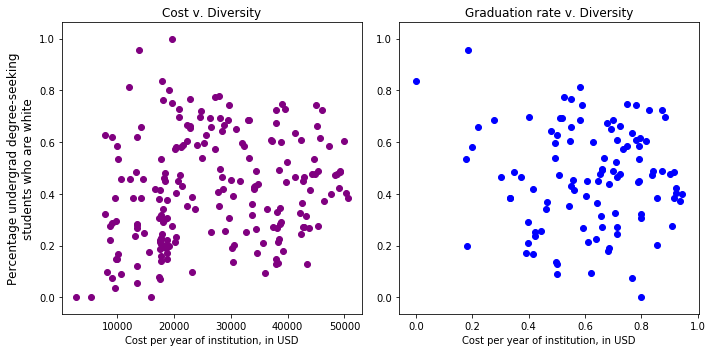

In [51]:
plt.figure(figsize=(10, 5))

ax1 = plt.subplot(1, 2, 1)
plt.scatter(x=wcs['TUITIONFEE_OUT'], y=wcs['UGDS_WHITE'], color='purple')
plt.xlabel('Cost per year of institution, in USD')
plt.ylabel('Percentage undergrad degree-seeking\nstudents who are white', fontsize=12)
plt.title('Cost v. Diversity')

ax2 = plt.subplot(1, 2, 2, sharey=ax1)
plt.scatter(x=priv_n_wcs['C150_4'], y=priv_n_wcs['UGDS_WHITE'], color='blue')
plt.xlabel('Cost per year of institution, in USD')
plt.title('Graduation rate v. Diversity')

plt.tight_layout()
plt.show()

There is no obvious or strong relationship between diversity and cost or diversity and graduation rate. In further research, we should include diversity into the scoring matrix to emphasize our interest in finding schools that are diverse.

### Conclusions and next steps

We've explored the distributions of and relationships between cost, quality and diversity in our subset of Oregon, Washingtong and California colleges. Next, we need a scoring matrix that will create college scoring measures for cost, quality and diversity, since our analysis shows that there are some tradeoffs related to each of these variables. The scoring matrix should allow a college to score well for having a lower cost, a higher quality of education as determined by entrance scores and completion rates, and more diversity. The suggested length of this assignment does not allow us to do it here so it will be left for future resarch.